## This notebook prvides the exploratory analysis based on textual data.

**Step 1: Set up the environment**

In [0]:
# Colab library to upload files to notebook
from google.colab import files
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Install Kaggle library
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#Download the dataset
!kaggle competitions download -c mercari-price-suggestion-challenge
# We unzip the downloaded .7z file
!apt-get install p7zip-full
!p7zip -d train.tsv.7z

 50% 17.0M/34.0M [00:00<00:00, 45.4MB/s]
100% 34.0M/34.0M [00:00<00:00, 97.7MB/s]
 64% 5.00M/7.77M [00:00<00:00, 17.1MB/s]
100% 7.77M/7.77M [00:00<00:00, 22.3MB/s]
 79% 59.0M/74.3M [00:00<00:00, 105MB/s] 
100% 74.3M/74.3M [00:00<00:00, 151MB/s]
 94% 277M/294M [00:02<00:00, 85.5MB/s]
100% 294M/294M [00:02<00:00, 124MB/s] 
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 143MB/s]
Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912

**Step 2: Exploratory Data Analysis with text processing**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import scipy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [0]:
df_price = pd.read_csv('train.tsv', sep='\t')
df_price.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [0]:
# Missing value imputing
df_price['category_name'].fillna(value='Other', inplace=True) 
# There's category name called "Other", and the missing categories can be entitled to that
df_price['brand_name'].fillna(value='Non-branded', inplace=True)
df_price['item_description'].fillna(value='No description provided', inplace=True)

Let's start with the simplest one. We will try to see if the length of the text has any effect on the price. 

In [0]:
length_of_description_character = df_price.item_description.astype('str').apply(lambda x:len(x))
cor_coef, p = scipy.stats.pearsonr(df_price.price, length_of_description_character)
print("Pearson correlation coefficient is {}".format(cor_coef))


Pearson correlation coefficient is 0.0480487319202747


Due to the extremely low Pearson correlation corfficient, the length of the description is likekly to be unrelated with price. However, we can try to get a better visual.

In [0]:
df_price['length_of_description_character'] = length_of_description_character

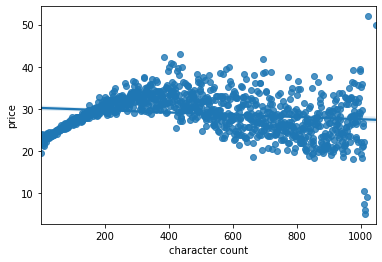

In [0]:
df = df_price.groupby('length_of_description_character')['price'].mean().reset_index()
sns.regplot(x=df["length_of_description_character"], y=(df["price"]))
plt.xlabel("character count")
plt.show()

So, although we can see an upward-trend in the beginning, after 200 characters, it loses any significance.

**Next, we will utilize the text description**

**Step 2.a: Normalization of the text**:

Normalization of text can be interpreted in many ways. However, we have to answer following questions: 

* Do you need to remove punctuations? The exclamatory sign can have important info, right?
* Do you need to remove stopwords?
* Is it necessary to lowercase everything ?

We will first remove the punctuations, remove stopwords and lowercase as well.

In [0]:
from string import punctuation

# Create a list of punctuation replacements
punctuation_list = []
for p in punctuation:
    punctuation_list.append((p, ''))
    
print(punctuation_list)

[('!', ''), ('"', ''), ('#', ''), ('$', ''), ('%', ''), ('&', ''), ("'", ''), ('(', ''), (')', ''), ('*', ''), ('+', ''), (',', ''), ('-', ''), ('.', ''), ('/', ''), (':', ''), (';', ''), ('<', ''), ('=', ''), ('>', ''), ('?', ''), ('@', ''), ('[', ''), ('\\', ''), (']', ''), ('^', ''), ('_', ''), ('`', ''), ('{', ''), ('|', ''), ('}', ''), ('~', '')]


In [0]:
# Examine list of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [0]:
# Write a function to remove punctuation, stopwords and lowercase all of them
import string

# Create a function to remove punctuations
def remove_punc(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Create a function to remove stop words
def remove_stopwords(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Create a function to lowercase the words
def to_lower(x):
    return x.lower()

The Question of whether we want a stemming or lemmatization is a difficult one. We will showb the effect of both and use one.

In [0]:
# Lemmatize the words
from nltk.stem import WordNetLemmatizer 

def lemmatize_basic(sentence):
  # sentence = remove_punc(sentence)
  # sentence = to_lower(sentence)
  pos_map = {'V':'v', 'J':'a'}
  words = nltk.word_tokenize(sentence)
  pos = nltk.pos_tag(words)
  lemmatizer = WordNetLemmatizer()
  lem_words = []
  for w in range(len(words)):
    try:
      lem_words.append(lemmatizer.lemmatize(words[w], pos_map[pos[w][1][0]]))
    except:
      lem_words.append(lemmatizer.lemmatize(words[w]))

  return ' '.join(lem_words)

# Stem the Words
from nltk.stem.porter import PorterStemmer


def stemming(sentence):
  words = nltk.word_tokenize(sentence)
  porter = PorterStemmer()
  return ' '.join([porter.stem(word) for word in words])


In [0]:
print('Actual description: ' + df_price['item_description'][500])
print('lemmatized: ' + lemmatize_basic(df_price['item_description'][500]))
print('Stemmed: ' + stemming(df_price['item_description'][500]))

Actual description: Brand new Price is firm Bundle orders to save on shipping :)
lemmatized: Brand new Price be firm Bundle order to save on shipping : )
Stemmed: brand new price is firm bundl order to save on ship : )


In [0]:
#Performing the normalization
%%time
df_price['item_description'] = df_price['item_description'].astype('str')

df_price['item_description'] = df_price['item_description'].apply(remove_punc)
df_price['item_description'] = df_price['item_description'].apply(to_lower)
df_price['item_description'] = df_price['item_description'].apply(remove_stopwords)
df_price['item_description'] = df_price['item_description'].apply(stemming)


df_price['name'] = df_price['name'].astype('str').apply(remove_punc)
df_price['name'] = df_price['name'].apply(remove_stopwords)
df_price['name'] = df_price['name'].apply(to_lower)

CPU times: user 13min 19s, sys: 2.18 s, total: 13min 21s
Wall time: 13min 21s


**Step 2.b: Textual Fetaure Extraction**

Next, we have to perform the feature extraction, transformation, and necessary engineering for the text

To convert the description or the text features into machine-interpretable feature set, we can take any of the following approaches:

* Countvectorizer
* TF-IDF

In [0]:
# For the item description, we will use the tf-idf method
# Perform a TFIDF Transformation of the item description with the top 100000 features and has an n-gram range of 1-2
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2), stop_words='english')
item_description_vectorized = tfidf.fit_transform(df_price['item_description'])

In [0]:
# #  create a dictionary mapping the tokens to their tfidf values

idf = sorted(list(zip(tfidf.get_feature_names(), tfidf.idf_)), key=lambda x:x[1], reverse=True)
print('words with highest inverse doc frequency')
idf[:10]


words with highest inverse doc frequency


[('bristl sabl', 13.59982678043031),
 ('flamingo floati', 13.59982678043031),
 ('wultra', 13.59982678043031),
 ('wultra matt', 13.59982678043031),
 ('zookki', 13.59982678043031),
 ('floati rm', 13.417505223636356),
 ('6x9 standard', 13.263354543809097),
 ('china slim', 13.01204011552819),
 ('cube left', 13.01204011552819),
 ('head suitabl', 12.906679599870365)]

In [0]:
print('words with lowest inverse doc frequency')
idf[-10:]

words with lowest inverse doc frequency


[('price', 3.275322344638819),
 ('worn', 3.1112172211534745),
 ('use', 2.994366110751689),
 ('free', 2.9234016791879487),
 ('brand new', 2.883069528182463),
 ('ship', 2.81852740437853),
 ('condit', 2.789476803151291),
 ('brand', 2.743215245974678),
 ('size', 2.30071601612866),
 ('new', 2.187134995826111)]

In [0]:

#The following part will be removed later:
# Creating new Category Features
def seperate_categories(category_name):
  # We observe that most entries have three category names seperated by a backslash. 
  # If we do not find such, we will return the miscellaneous category.
    try:
        main_cat, sub_cat1, sub_cat2= category_name.split('/')
        return main_cat, sub_cat1, sub_cat2
    except:
        return 'Other','Other','Other'

df_price['category_main'], df_price['category_sub1'], df_price['category_sub2'] = zip(*df_price['category_name'].apply(seperate_categories))

In [0]:
# CountVectorizer - name & categories
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(df_price['name'])
X_category_main = cv.fit_transform(df_price['category_main'])
X_category_sub1 = cv.fit_transform(df_price['category_sub1'])
X_category_sub2 = cv.fit_transform(df_price['category_sub2'])

**Step 2.c: Topic Modeling**
Now, we can observe, if we can have some insights from the topic modeling


In [0]:
df_price_sample = df_price.sample(frac=0.01).reset_index(drop=True)

In [0]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np


# Initialize CountVectorizer
cvectorizer = CountVectorizer(max_features=20000,
                              stop_words='english', 
                              lowercase=True)

# Fit it to our dataset
cvz = cvectorizer.fit_transform(df_price_sample['item_description'])

# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_components=10,
                                      random_state=42)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(cvz)

# Define variables
n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: free | home | smoke | brush | pet | new | bra | color | wash | set
Topic 1: iphon | charger | work | card | includ | appl | ipad | phone | batteri | charg
Topic 2: price | leather | pocket | size | bag | color | insid | zipper | purs | offer
Topic 3: ship | free | rm | bundl | price | item | new | pleas | firm | day
Topic 4: descript | inch | month | sticker | babi | necklac | chain | pink | white | blue
Topic 5: new | brand | box | color | size | tag | use | come | authent | bag
Topic 6: condit | size | worn | great | good | use | time | excel | stain | small
Topic 7: case | pleas | ship | iphon | list | item | bundl | free | price | purchas
Topic 8: use | color | skin | rm | light | includ | great | oil | make | palett
Topic 9: size | new | fit | tag | worn | small | black | medium | pink | brand
CPU times: user 40.1 s, sys: 16 ms, total: 40.1 s
Wall time: 40.1 s
